# Does Weather has an significant impact on the number of highway

traffic accidents?

Felix Büppelmann  
2023-06-16

## Summary

Analysis of weather events on German highways and accidents in 2018-19.

## Rationale

It analyses whether highway segments that are particularly exposed to
extreme weather events result in more car crashes than usual.

## Datasources

### Highway Weather Data

-   Metadata: [URL](https://mobilithek.info/offers/-3534538293975156153)
-   Data:
    [URL](https://www.mcloud.de/downloads/mcloud/96EA9CD1-0695-4461-90B1-BC6F6B0E0729/%3EResultat_HotSpot_Analyse_neu.csv)
-   Data Type: CSV
-   Description: Weather events on specific routes were studied using
    reanalysis data from all of Germany from Dec. 1, 2017-Nov. 30, 2019.
    The weather values of 3160 points with 1 km distance were read from
    the data and averaged or summed up, depending on the parameter. The
    values were normalized and the highest was given the value 100, the
    lowest the value 0.

### CrashData

-   Metadata:
    [URL](https://www.opengeodata.nrw.de/produkte/transport_verkehr/unfallatlas/)
-   Data:
    [2017](https://www.opengeodata.nrw.de/produkte/transport_verkehr/unfallatlas/Unfallorte2017_EPSG25832_CSV.zip)
    [2018](https://www.opengeodata.nrw.de/produkte/transport_verkehr/unfallatlas/Unfallorte2018_EPSG25832_CSV.zip)
    [2019](https://www.opengeodata.nrw.de/produkte/transport_verkehr/unfallatlas/Unfallorte2019_EPSG25832_CSV.zip)
-   Data Type: ZIP/CSV
-   Description: Road traffic accident data of 2017 to 2019 of Germany.

## Transformations

1.  Preporcessing of the weather data
    -   Give each weather measure point a unique ID
    -   As the measure points are distributed one kilometer apart from
        each other, each points gets an kilomter marker
2.  Preprocessing of the crash data
    -   Dropping rows with irrelevant data (turn accidents, bike
        accidents, etc.)
    -   Drop columns with irrelevant data
3.  Connect the crash data with the weather data
    -   For each crash, find the closest weather measure point
        (Treshold: 600m)
        -   Drop rows where no point is within the treshold
        -   If there are multiple points within the treshold, select the
            one closest
    -   Merge crash data to the weather data
4.  Normalize the combined data per Route

## Analysis

#### Setup Code

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

data = pd.read_sql_table('weatherCrashData', 'sqlite:///final_report_data.sqlite')
data_per_route = pd.read_sql_table('weatherCrashDataNormalized', 'sqlite:///final_report_data.sqlite')

def locationMap(df, color, title, zoom=4):
  fig = px.scatter_mapbox(df, lat='Latitude', 
  lon='Longitude', 
  color=color,  
  size_max=8,
  zoom=zoom,
  height=500,
  hover_data={'Latitude': False, 'Longitude': False, 'Strecke': True, 'Kilometer': True},
  center={'lat': df['Latitude'].mean(), 'lon': df['Longitude'].mean()})
  fig.update_layout(mapbox_style='outdoors', mapbox_accesstoken='pk.eyJ1IjoibGlmZW9mZmVsaXh0IiwiYSI6ImNsaXQ2aHB6ZzBsc2ozcW96MjdvZmc3azIifQ.N5nMWySGLLJcjh0Ha1e9CA')
  fig.update_layout(title_text=title, title_x=0.5)
  return fig

def densityMap(df, z, title, zoom=4):
  fig = px.density_mapbox(df, lat='Latitude', 
  lon='Longitude',  
  z=z, 
  radius=3,
  zoom=zoom,
  height=500,
  hover_data={'Latitude': False, 'Longitude': False, 'Strecke': True, 'Kilometer': True},
  center={'lat': df['Latitude'].mean(), 'lon': df['Longitude'].mean()},
  template='seaborn')
  fig.update_layout(mapbox_style='outdoors', mapbox_accesstoken='pk.eyJ1IjoibGlmZW9mZmVsaXh0IiwiYSI6ImNsaXQ2aHB6ZzBsc2ozcW96MjdvZmc3azIifQ.N5nMWySGLLJcjh0Ha1e9CA')
  fig.update_layout(title_text=title, title_x=0.5)
  return fig

def correlationPlot(df, columns_to_exclude, title):
  # Select only the columns of interest
  selected_columns = [col for col in df.columns if col not in columns_to_exclude]

  # Calculate the correlation matrix
  corr_matrix = df[selected_columns].corr()

  # Plot the correlation matrix
  plt.figure(figsize=(10, 8))
  sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
  plt.title(title)
  return plt, corr_matrix

def linePlot(df, x, y, title, x_title, y_title):
  fig = px.line(df, x=x, y=y, title=title, template='seaborn')
  fig.update_layout(xaxis_title=x_title, yaxis_title=y_title)
  fig.update_layout(legend=dict(
    title=''
))
  return fig

if not os.path.exists('images'):
    os.mkdir('images')

def save_image(fig, name):
  location = os.path.join('images', name)
  if not os.path.exists(location):
    fig.write_image(location)

### Analysis of all routes combines

During the first analysis all routes are looked at. The first map shows
the location of the routes. The second map shows the number of crashes
per kilometer normalized. The third map shows the normalized weather
events per kilometer. The higher the number the more and severe weather
events occured.

In [2]:
fig_1 = locationMap(data, 'Strecke', 'Map of all the routes', zoom=4)
save_image(fig_1, 'Strecke.png')

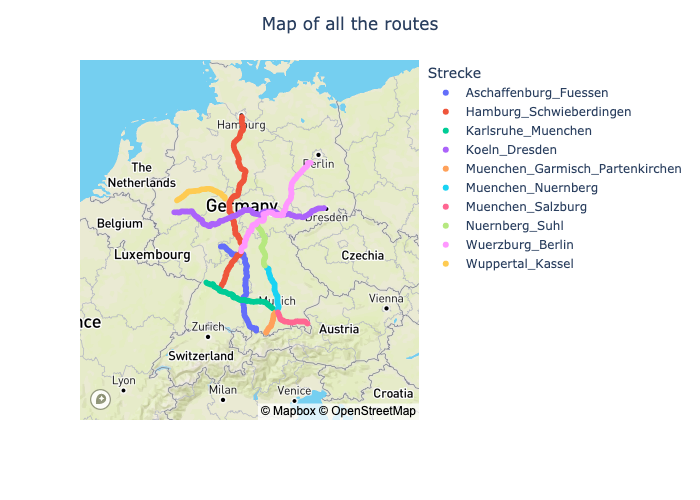

In [4]:
fig_2 = densityMap(data, 'NormalizedCrash', 'Map of all the crashes along the routes')
save_image(fig_2, 'Crash.png')

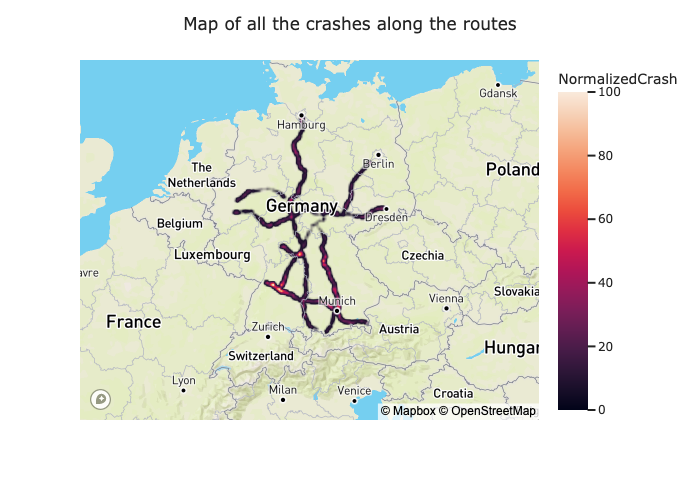

In [6]:
fig_3 = densityMap(data, 'Gesamt', 'Map of the weather events combined along the routes')
save_image(fig_3, 'Weather.png')

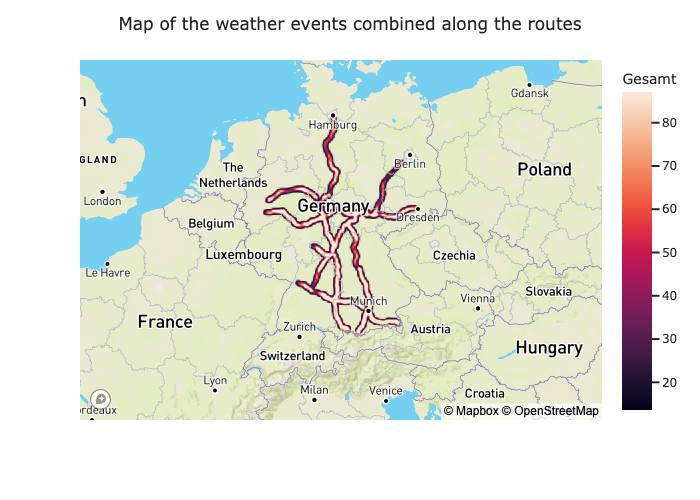

It can be seen that the number of crashes is higher in the south of
Germany. The weather events are also more severe in the south. My
hypothesis is that the weather events have an impact on the number of
crashes. Therefore a correlation analysis is performed.

#### Correlation Analysis

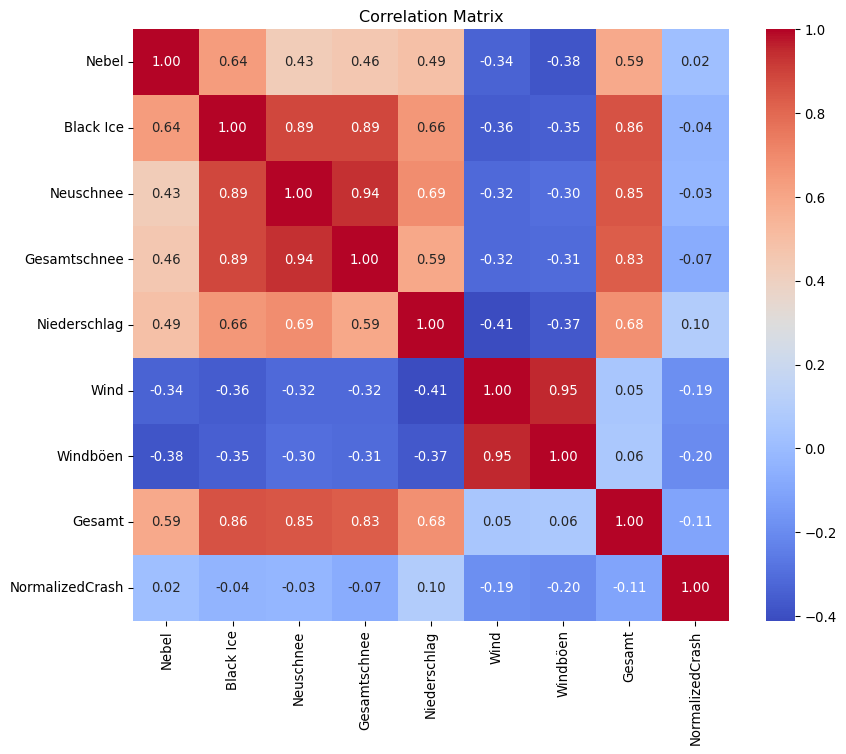

In [8]:
# List of columns to exclude from correlation calculation
columns_to_exclude = ['index','Strecke', 'StreckeID', 'Kilometer', 'Count', 'CrashCount', 'CrashCountWet', 'CrashCountSnow', 'CrashCountWetSnow','Latitude', 'Longitude', 'NormalizedCrashWet', 'NormalizedCrashSnow', 'NormalizedCrashWetSnow']  # Add the column names you want to exclude


plt, corr_matrix = correlationPlot(data, columns_to_exclude, 'Correlation Matrix')
plt.show()

The correlation matrix shows that there are following weather events
that have a high correlation with the number of crashes:

In [9]:
# Find the column(s) with the highest correlation coefficient(s)
highest_corr = corr_matrix['NormalizedCrash'].abs().nlargest(5)  
top_weather_phenomena = highest_corr.index[1:]  
top_weather_phenomena

Index(['Windböen', 'Wind', 'Gesamt', 'Niederschlag'], dtype='object')

It is interesting that the number of crashes is not strongly correlated
with the number of weather events. Further it is interesting that the
top correlated weather events are ‘Windböen’ and ‘Wind’ which are both
related to wind, and these are correlated negativly. Which means that
the more wind there is on a highway, the less crashes happen. This is
counterintuitive. One possible reason for that is that people drive more
carefully when there is more wind, but this is speculation.

The only positive correlation is with ‘Niederschlag’ which means that
the more precipitation there is, the more crashes happen. This seams
reasonable.

#### Feature Importance

A further analyis is the feature importance of a Random Forest Regressor
which tries to predict how likely a crash is based on the weather input.

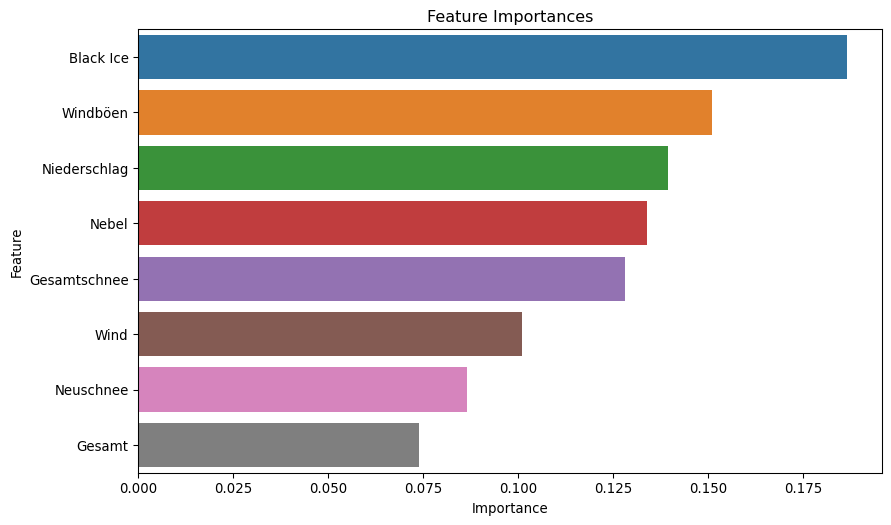

In [10]:
# List of columns to exclude from correlation calculation
columns_to_exclude = ['index','Strecke', 'StreckeID', 'Kilometer', 'Count', 'CrashCount', 'CrashCountWet', 'CrashCountSnow', 'CrashCountWetSnow','Latitude', 'Longitude', 'NormalizedCrash', 'NormalizedCrashWet', 'NormalizedCrashSnow', 'NormalizedCrashWetSnow']  

# Select only the columns of interest
selected_columns = [col for col in data.columns if col not in columns_to_exclude]


X = data[selected_columns] 
y = data['NormalizedCrash']

# Create a random forest regressor
rf = RandomForestRegressor()

# Train the model
rf.fit(X, y)

# Get feature importances
importances = rf.feature_importances_

# Create a dataframe to store feature importances
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
# Sort the feature importances
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In a random forest regressor model the weather effect which is most
important for predicting the likelihood of a crash is ‘Black Ice’. Which
can be reasonable as Driver may get suprised by ice on the road. Sadly
there no way to filter the crash data for accidents that occur due to
Ice. This is also true for the second most important feature ‘Windböen’.
Overall it can be said that none of these feature sticks out
significantly. As ‘Niederschlag’ is one feature that the crash data can
be filtered for, this is done in the next step.

### Analysis of crashes during precipitation

To explore this further the data is filtered for crashes that happened
during or due to precipitation. The following map shows the location of
crashes in the wet. The secod map shows the precipitation along the
routes.

In [11]:
fig_4 = densityMap(data, 'NormalizedCrashWet', 'Map of all the crashes in the Wet along the routes')
save_image(fig_4, 'CrashWet.png')

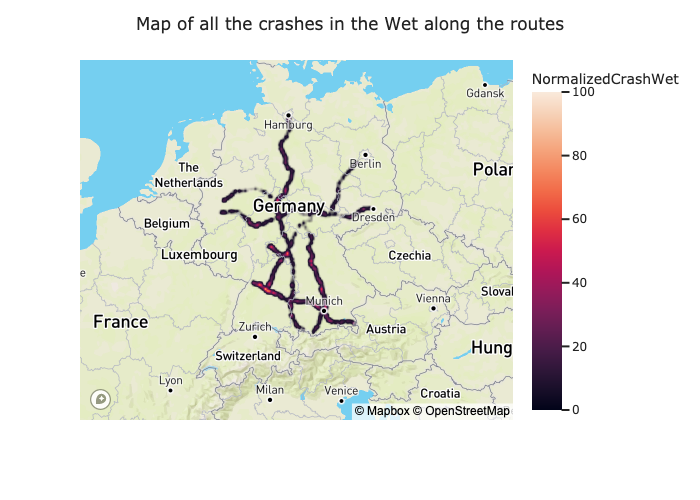

In [13]:
fig_5 = densityMap(data, 'Niederschlag', 'Map of the precipitation along the routes')
save_image(fig_5, 'Precipitation.png')

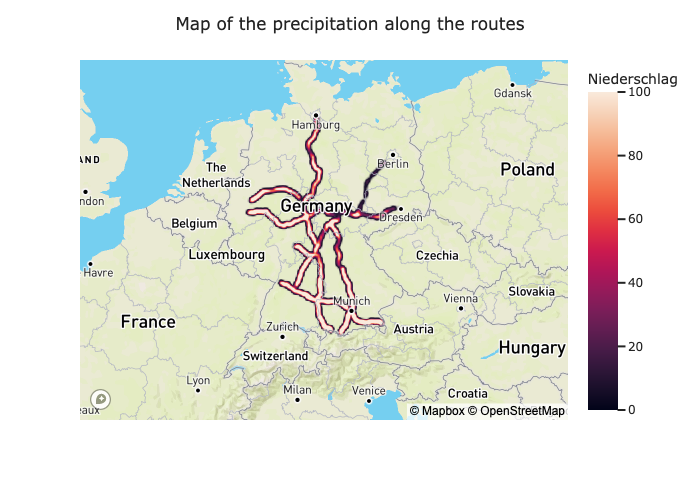

When you overlay the maps in your mind you can see that they are kind of
similar. Areas where less precipitation is measured have less crashes
and areas with more precipitation have more crashes. This is not a
strong correlation but it is visible. In the following the correlation
is calculated between all relevant .

#### Correlation Analysis

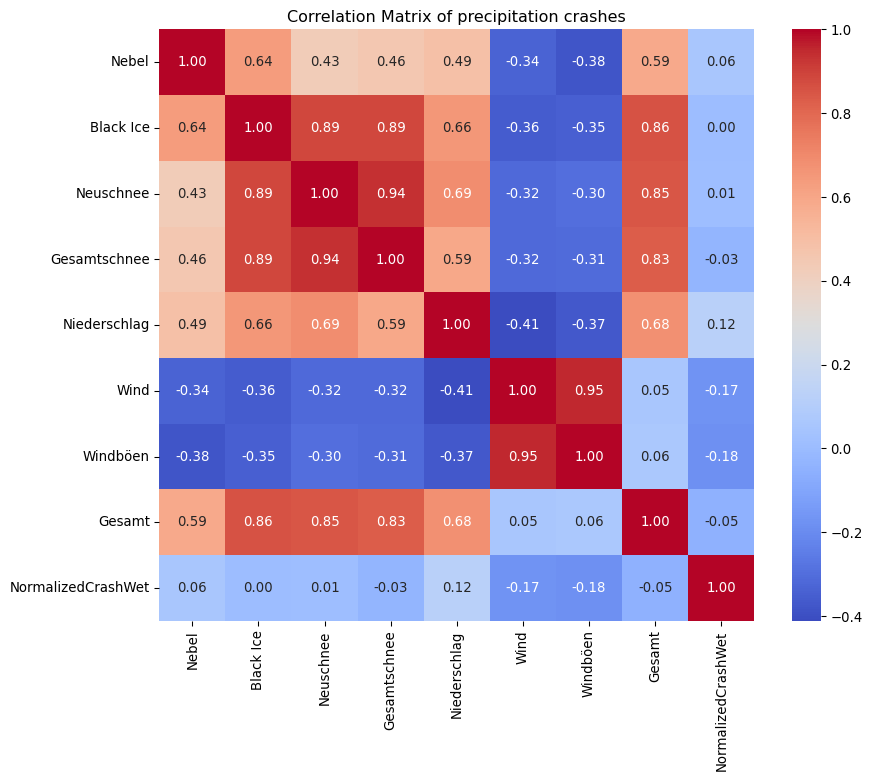

In [15]:
# List of columns to exclude from correlation calculation
columns_to_exclude = ['index','Strecke', 'StreckeID', 'Kilometer', 'Count', 'CrashCount', 'CrashCountWet', 'CrashCountSnow', 'CrashCountWetSnow','Latitude', 'Longitude', 'NormalizedCrash', 'NormalizedCrashSnow', 'NormalizedCrashWetSnow']  # Add the column names you want to exclude

plt, corr_matrix = correlationPlot(data, columns_to_exclude, 'Correlation Matrix of precipitation crashes')
plt.show()

There is not much difference to the correlation matrix of all crashes.
The only difference is that the correlation between ‘Niederschlag’ and
‘NormalizedCrashWet’ is higher. Which seems obvious.

In [16]:
# Find the column(s) with the highest correlation coefficient(s)
highest_corr = corr_matrix['NormalizedCrashWet'].abs().nlargest(5)  
top_weather_phenomena = highest_corr.index[1:]  
top_weather_phenomena

Index(['Windböen', 'Wind', 'Niederschlag', 'Nebel'], dtype='object')

### Analysis of crashes due to snow

Another kind of precipitation is snow. It is investigated because the
crash data can be filtered for crashes that happened during or due to
snow. The following map shows the location of crashes due of snow. The
second map shows the snow along the routes.

In [17]:
fig_6 = densityMap(data, 'NormalizedCrashSnow', 'Map of all the crashes in the Snow along the routes')
save_image(fig_6, 'CrashSnow.png')

\[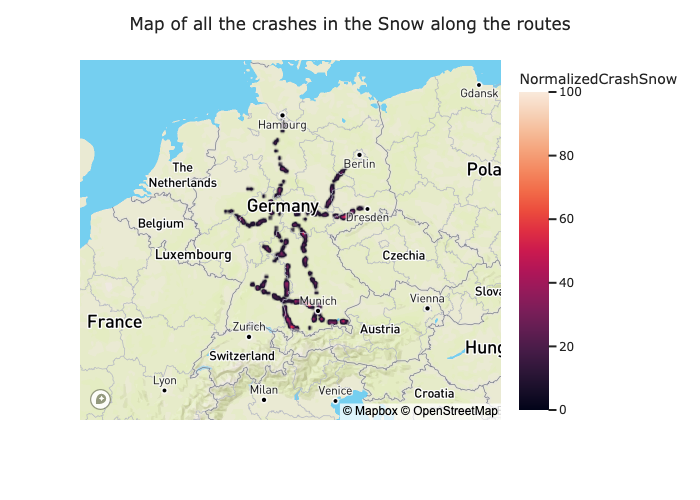\]

In [19]:
fig_7 = densityMap(data, 'Gesamtschnee', 'Map of the snow along the routes')
save_image(fig_7, 'Snow.png')

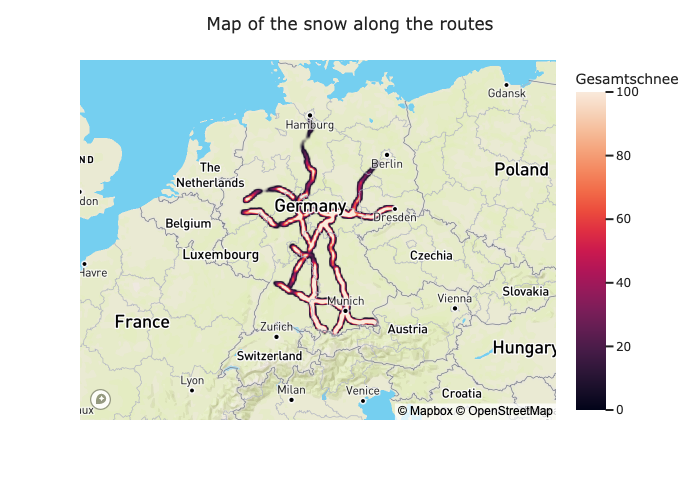

When you overlay the maps in your mind you can see that they are kind of
similar. Areas where less snow is measured have less crashes and areas
with more snow have more crashes. This is not a strong correlation but
it is visible. In the following the correlation is calculated between
all relevant.

#### Correlation Analysis

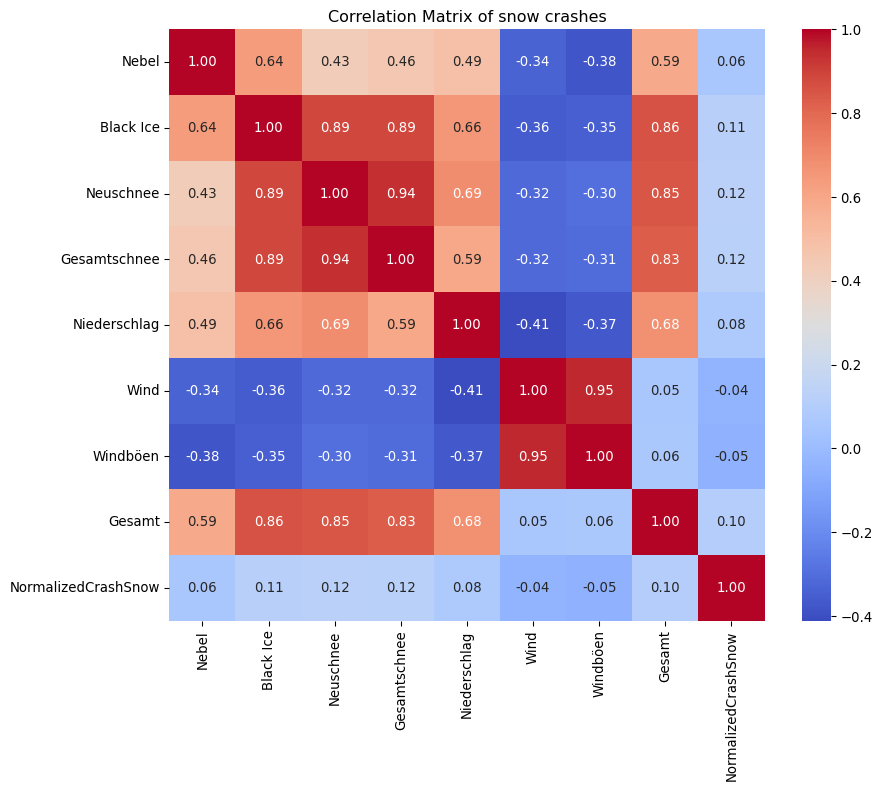

In [21]:
# List of columns to exclude from correlation calculation
columns_to_exclude = ['index','Strecke', 'StreckeID', 'Kilometer', 'Count', 'CrashCount', 'CrashCountWet', 'CrashCountSnow', 'CrashCountWetSnow','Latitude', 'Longitude', 'NormalizedCrash', 'NormalizedCrashWet', 'NormalizedCrashWetSnow']  # Add the column names you want to exclude

plt, corr_matrix = correlationPlot(data, columns_to_exclude, 'Correlation Matrix of snow crashes')
plt.show()

There is not much difference to the correlation matrix of all crashes.
The only difference is that the correlation between ‘Gesamtschnee’ and
‘Neuschnee’ and ‘NormalizedCrashSnow’ is higher. Which seems obvious.

In [22]:
# Find the column(s) with the highest correlation coefficient(s)
highest_corr = corr_matrix['NormalizedCrashSnow'].abs().nlargest(5)  
top_weather_phenomena = highest_corr.index[1:]  
top_weather_phenomena

Index(['Neuschnee', 'Gesamtschnee', 'Black Ice', 'Gesamt'], dtype='object')

### Analysis of one route with relativ high crash occurence (Karlsruhe - Munich)

When you look at the map of all crashes you can see that there is one
route with a relativ high crash occurence. This route is the A8 from
Karlsruhe to Munich. In the following the crashes on this route are
analyzed in more detail.

In [23]:
fig_8 = densityMap(data_per_route[data_per_route['Strecke'] == 'Karlsruhe_Muenchen'], 'NormalizedCrash', 'Map of the crashes along the route Karlsruhe to Munich', zoom=4.5)
save_image(fig_8, 'CrashKarlsruheMunich.png')

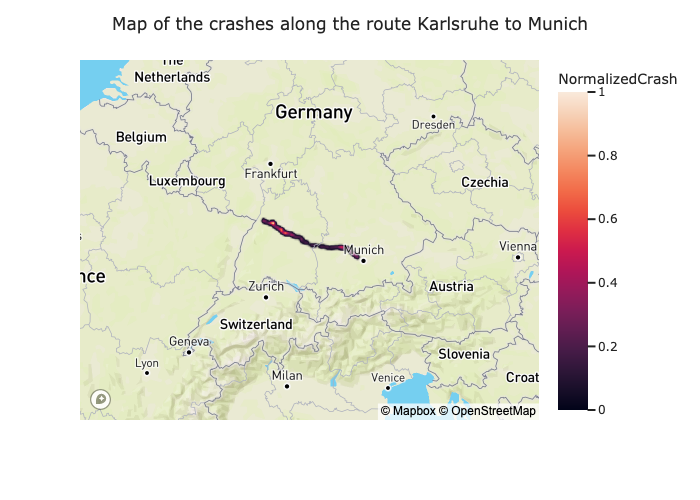

In [25]:
fig_9 = densityMap(data_per_route[data_per_route['Strecke'] == 'Karlsruhe_Muenchen'], 'Gesamt', 'Map of the weather events combined along the route Karlsruhe to Munich', zoom=4.5)
save_image(fig_9, 'WeatherKarlsruheMunich.png')

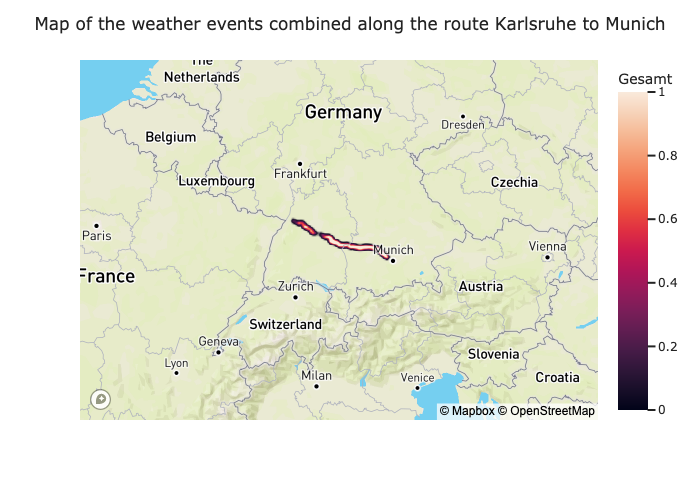

When you compare the two maps it is visible that in areas with more
(severe) weather events less crashs happen. This is an indicator for the
fact that the weather events are not the main reason for the crashes and
that the correlation seems to be negative. In the following the
correlation is calculated between all relevant features is calculated.

#### Karlsruhe - Munich Correlation Analysis

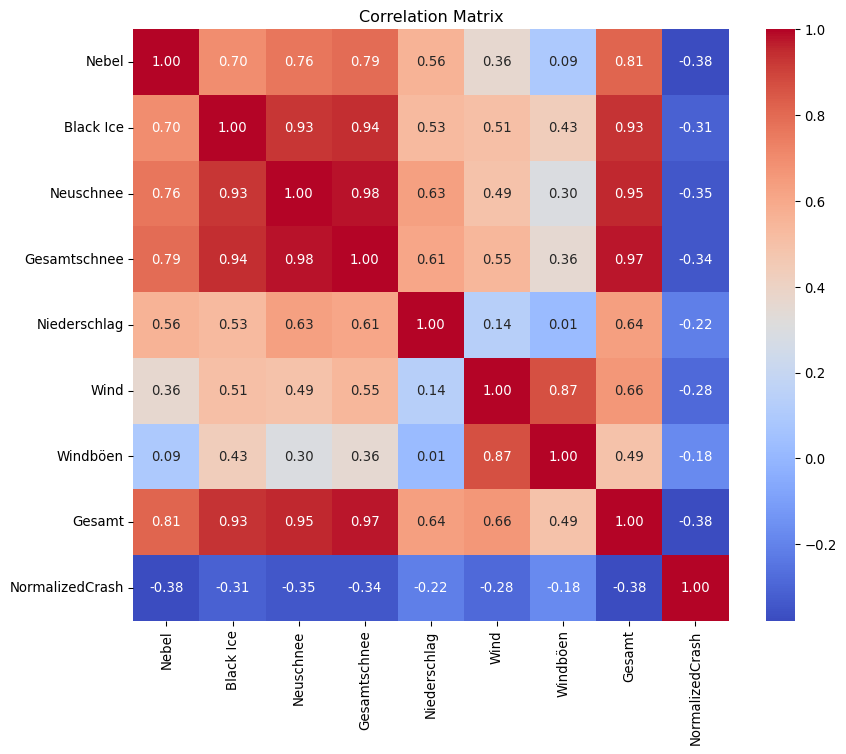

In [27]:
# List of columns to exclude from correlation calculation
columns_to_exclude = ['index','Strecke', 'StreckeID', 'Kilometer', 'Count', 'CrashCount', 'CrashCountWet', 'CrashCountSnow', 'CrashCountWetSnow','Latitude', 'Longitude', 'NormalizedCrashWet', 'NormalizedCrashSnow', 'NormalizedCrashWetSnow', 'SmoothedCrash', 'SmoothedCrashWet', 'SmoothedCrashSnow', 'SmoothedCrashWetSnow']  # Add the column names you want to exclude


plt, corr_matrix = correlationPlot(data_per_route[data_per_route['Strecke'] == 'Karlsruhe_Muenchen'], columns_to_exclude, 'Correlation Matrix')
plt.show()

The correlation matrix shows that there are following weather events
that have a high correlation with the number of crashes:

In [28]:
# Find the column(s) with the highest correlation coefficient(s)
highest_corr = corr_matrix['NormalizedCrash'].abs().nlargest(5)  
top_weather_phenomena = highest_corr.index[1:]  
top_weather_phenomena

Index(['Nebel', 'Gesamt', 'Neuschnee', 'Gesamtschnee'], dtype='object')

As suspected the correlation is negative. This means that the more
weather events happen the less crashes happen. This is an indicator that
the weather events are not the main reason for the crashes. Furthere
analysis on filtered data after wet and snow crashes are not done
because the correlation is negative and the weather events are not the
main reason for the crashes.

#### Karlruhe to Munich Weather Events and Crashes per Kilometer

The final analysis is done by looking at the weather events and crashes
per kilometer. This is done to see if there are areas with more weather
events and crashes. Especially the weather Events ‘Gesamt’,
‘Niederschlag’, ‘Gesamtschnee’ and ‘Wind’ are analyzed.

In [29]:
fig_10 = linePlot(data_per_route[data_per_route['Strecke'] == 'Karlsruhe_Muenchen'], 'Kilometer', ['SmoothedCrash','Gesamt', 'Niederschlag', 'Gesamtschnee', 'Wind'], 'Crash and Weather Events per Kilometer', 'Kilometer', '')
save_image(fig_10, 'KarlsruheMunichKilometer.png')

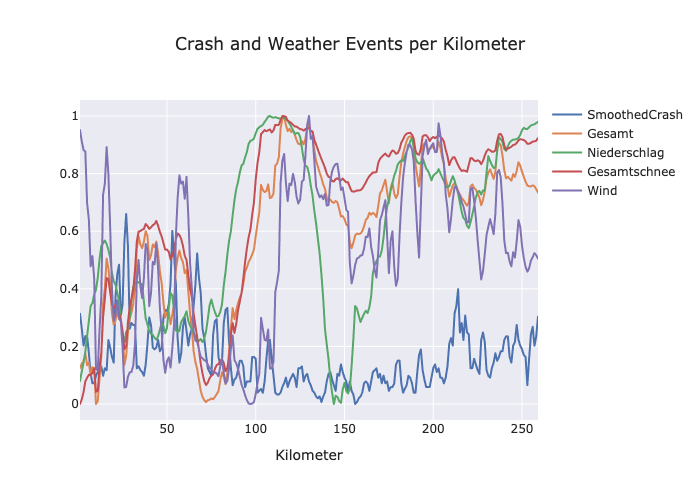

The graph underlines the negative correlation between weather events and
crashes. The more weather events happen the less crashes happen.

## Conclusion

The analysis investigates whether highway segments exposed to extreme
weather events lead to more car crashes. Here are the key findings:

1.  Initial Analysis:
    -   The number of crashes is higher in the south of Germany, where
        severe weather events also occur more frequently.
2.  Correlation Analysis:
    -   The correlation between the number of crashes and weather events
        is not strong.
    -   Wind-related events are negatively correlated with crashes,
        indicating that more wind on the highway is associated with
        fewer crashes.
    -   ‘Niederschlag’ (precipitation) shows a positive correlation,
        meaning that more precipitation leads to more crashes.
3.  Random Forest Regressor:
    -   ‘Black Ice’ and ‘Windböen’ are the most important weather
        factors for predicting crash likelihood.
    -   None of the features stand out significantly in predicting crash
        likelihood.
4.  Analysis of Wet Conditions:
    -   Areas with more precipitation tend to have more crashes, but the
        correlation is not strong.
5.  Analysis of Snow Conditions:
    -   Areas with more snow tend to have more crashes, but the
        correlation is not strong.
6.  Analysis of A8 Route (Karlsruhe - Munich):
    -   The A8 route shows a relatively high occurrence of crashes.
    -   Contrary to expectations, areas with more severe weather events
        on this route have fewer crashes.
    -   There is a negative correlation between weather events and
        crashes on this particular route.
    -   Weather events may not be the primary cause of crashes on the A8
        route.

In summary, the analysis does not strongly support the hypothesis that
highway segments exposed to extreme weather events result in more car
crashes. The correlation analysis and specific route analysis suggest
that weather events may not be the main contributing factor to the
observed crashes.